In [237]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
import clip
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [238]:
# Extracting CLIP Image features
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess_clip = clip.load("ViT-B/32", device=device)

In [239]:
# for text embeddings
import pandas as pd

# Load your file
df = pd.read_csv("/Users/fatimatuzzahra/Downloads/ADNI1_Merged_AllImages.csv")

# Preview the first few rows
print(df.shape)
df.head()


(2294, 51)


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,...,AXCRYING,AXELMOOD,AXWANDER,AXFALL,AXOTHER,ID,SITEID,USERDATE,USERDATE2,update_stamp
0,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/1/2008,...,1.0,1.0,1.0,1.0,1.0,4150.0,127.0,5/5/2008,NaN,00:00.0
1,I97341,941_S_1311,MCI,M,70,m06,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,...,1.0,1.0,1.0,1.0,2.0,2370.0,127.0,9/18/2007,NaN,00:00.0
2,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/2/2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I63874,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,...,1.0,1.0,1.0,2.0,1.0,2110.0,127.0,8/15/2007,NaN,00:00.0


In [240]:
import pandas as pd
import numpy as np
import torch
import clip

# Load CSV
df = pd.read_csv("/Users/fatimatuzzahra/Downloads/ADNI1_Merged_AllImages.csv")

# 🔹 Step 1: Keep label and encode it numerically
label_map = {'AD': 0, 'CN': 0, 'MCI': 2}
df = df[df['Group'].isin(label_map)]  # filter out unknowns
df['label'] = df['Group'].map(label_map)

# 🔹 Step 2: Prepare text input (excluding label columns)
# Columns to drop
drop_cols = [
    'Group', 'Modality', 'Format', 'Downloaded', 'Description', 'Type',
    'Acq Date', 'Subject', 'USERDATE', 'USERDATE2', 'update_stamp', 
    'SITEID', 'VISCODE', 'VISCODE2'
]

# Optional: drop more based on duplication or redundancy
df_filtered = df.drop(columns=drop_cols)

# 🔹 Optional: Keep Image IDs if you want to track
image_ids = df["Image Data ID"].astype(str).str.strip()


# 🔹 Step 3: Combine row text into string per patient
df_text = df_filtered.drop(columns=["label", "Image Data ID"])
texts = df_text.astype(str).agg(" ".join, axis=1).tolist()

# 🔹 Step 4: Tokenize with CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
text_tokens = clip.tokenize(texts, truncate=True).to(device)

# 🔹 Step 5: Generate text embeddings
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens).cpu().numpy()

# 🔹 Step 6: Save embeddings and labels (ready for training!)
np.save("train_text_features_only.npy", text_embeddings)
np.save("train_text_labels_only.npy", df_filtered['label'].values)

# Optional: save a CSV for review
df_out = pd.DataFrame(text_embeddings)
df_out['label'] = df_filtered['label'].values
df_out.to_csv("train_text_features_with_labels.csv", index=False)

print("Saved:")
print(" - train_text_features_only.npy", text_embeddings.shape)
print(" - train_text_labels_only.npy", df_filtered['label'].shape)

Saved:
 - train_text_features_only.npy (2294, 512)
 - train_text_labels_only.npy (2294,)


In [241]:
df = pd.read_csv("train_text_features_with_labels.csv", header=0)

# Preview the first few rows
print(df.shape)
df.head()

print("Final dataframe shape:", df.shape)
print("All column names:", df.columns.tolist())

(2294, 513)
Final dataframe shape: (2294, 513)
All column names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '

CHECK FOR DATA OVERLAPPING

In [242]:
import numpy as np
import os

# Load original image paths
train_paths = np.load("train_image_paths_axial.npy", allow_pickle=True)
val_paths = np.load("val_image_paths_axial.npy", allow_pickle=True)
test_paths = np.load("test_image_paths_axial.npy", allow_pickle=True)

# Extract image IDs (e.g., "I12345_AD_axial_55.png" → "I12345")
def extract_ids(paths):
    return set(os.path.basename(p).split("_")[0] for p in paths)

train_ids = extract_ids(train_paths)
val_ids = extract_ids(val_paths)
test_ids = extract_ids(test_paths)

# 1. Check for overlaps between splits
overlap_train_val = train_ids & val_ids
overlap_train_test = train_ids & test_ids
overlap_val_test = val_ids & test_ids

# Print results
print("🔍 Checking for ID overlaps between splits:")
print("Train ∩ Val:", len(overlap_train_val))
print("Train ∩ Test:", len(overlap_train_test))
print("Val ∩ Test:", len(overlap_val_test))

# 2. (Optional) Also check if any text_image_ids are used in multiple splits
text_ids = np.load("text_image_ids.npy", allow_pickle=True)
text_ids_set = set(text_ids)

text_in_train = text_ids_set & train_ids
text_in_val = text_ids_set & val_ids
text_in_test = text_ids_set & test_ids

print("\n📦 Text sample distribution:")
print("Text IDs in Train:", len(text_in_train))
print("Text IDs in Val:", len(text_in_val))
print("Text IDs in Test:", len(text_in_test))

# Sanity check for overlaps in textual split
print("\n🔁 Overlap in Textual Data:")
print("Text Train ∩ Val:", len(text_in_train & text_in_val))
print("Text Train ∩ Test:", len(text_in_train & text_in_test))
print("Text Val ∩ Test:", len(text_in_val & text_in_test))

🔍 Checking for ID overlaps between splits:
Train ∩ Val: 0
Train ∩ Test: 0
Val ∩ Test: 0

📦 Text sample distribution:
Text IDs in Train: 1541
Text IDs in Val: 153
Text IDs in Test: 226

🔁 Overlap in Textual Data:
Text Train ∩ Val: 0
Text Train ∩ Test: 0
Text Val ∩ Test: 0


In [243]:
import torch.nn as nn

# --------------------- Define MLP Model ---------------------
class MLPWithDropout(nn.Module):
    def __init__(self):
        super(MLPWithDropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)



In [244]:
import os

# Load the image split path files
train_paths = np.load("train_image_paths_axial.npy", allow_pickle=True)
val_paths = np.load("val_image_paths_axial.npy", allow_pickle=True)
test_paths = np.load("test_image_paths_axial.npy", allow_pickle=True)

def extract_ids(paths):
    return set(os.path.basename(p).split("_")[0] for p in paths)

train_ids = extract_ids(train_paths)
val_ids = extract_ids(val_paths)
test_ids = extract_ids(test_paths)

In [245]:
# Load your text embeddings and image IDs:

text_embeddings = np.load("train_text_features_only.npy")
text_labels = np.load("train_text_labels_only.npy")

df = pd.read_csv("/Users/fatimatuzzahra/Downloads/ADNI1_Merged_AllImages.csv")
# ✅ Correct column to use for text IDs
text_ids = df['Image Data ID'].astype(str).str.strip().values

# (Optional) Save them for later use
np.save("text_image_ids.npy", text_ids)

In [246]:
import numpy as np
import os

# Load your arrays
image_paths = np.load("train_image_paths_axial.npy", allow_pickle=True)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)

# Extract just the ID part from image filenames
image_ids = set(os.path.basename(p).split("_")[0] for p in image_paths)

# Convert text_ids to set (if they aren't already)
text_ids_set = set(text_ids)

# Find matches
matched_ids = image_ids & text_ids_set
unmatched_text_ids = text_ids_set - image_ids
unmatched_image_ids = image_ids - text_ids_set

print(f"✅ Matched IDs: {len(matched_ids)}")
print(f"❌ Unmatched Text IDs: {len(unmatched_text_ids)}")
print(f"❌ Unmatched Image IDs: {len(unmatched_image_ids)}")
print(f"Total Image IDs: {len(image_ids)}")
print(f"Total Text IDs: {len(text_ids_set)}")

✅ Matched IDs: 1541
❌ Unmatched Text IDs: 753
❌ Unmatched Image IDs: 0
Total Image IDs: 1541
Total Text IDs: 2294


In [247]:
# Now match and split

train_feats, val_feats, test_feats = [], [], []
train_labs, val_labs, test_labs = [], [], []

for emb, label, tid in zip(text_embeddings, text_labels, text_ids):
    tid_str = str(tid)
    if tid_str in train_ids:
        train_feats.append(emb)
        train_labs.append(label)
    elif tid_str in val_ids:
        val_feats.append(emb)
        val_labs.append(label)
    elif tid_str in test_ids:
        test_feats.append(emb)
        test_labs.append(label)

In [276]:
# Convert and save if needed (for cross-checking

train_feats, val_feats, test_feats = map(np.array, [train_feats, val_feats, test_feats])
train_labs, val_labs, test_labs = map(np.array, [train_labs, val_labs, test_labs])

np.save("text_train_features.npy", train_feats)
np.save("text_train_labels.npy", train_labs)

np.save("text_val_features.npy", val_feats)
np.save("text_val_labels.npy", val_labs)

np.save("text_test_features.npy", test_feats)
np.save("text_test_labels.npy", test_labs)

print("Train:", train_feats.shape)
print("Val:", val_feats.shape)
print("Test:", test_feats.shape)

Train: (1541, 512)
Val: (153, 512)
Test: (226, 512)


In [277]:
import random
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import gc
from collections import Counter

# 🧬 Set seed
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# 🔒 Deterministic mode
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def set_weights(module):
    if isinstance(module, nn.Linear):
        torch.manual_seed(seed)
        torch.nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)

model = MLPWithDropout()
model.apply(set_weights)

MLPWithDropout(
  (net): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [278]:
train_losses = []
val_losses = []

# --------------------- Load Data ---------------------
X_train = np.load("text_train_features.npy")
y_train = np.load("text_train_labels.npy")

X_val = np.load("text_val_features.npy")
y_val = np.load("text_val_labels.npy")

# --------------------- Convert --------------------------
# Filter only samples with label 0, 1, or 2
valid_indices_train = np.isin(y_train, [0, 1, 2])
valid_indices_val = np.isin(y_val, [0, 1, 2])

X_train = X_train[valid_indices_train]
y_train = y_train[valid_indices_train]
X_val = X_val[valid_indices_val]
y_val = y_val[valid_indices_val]

# Convert to binary: 1 for MCI (label=2), else 0
y_train = np.array([1 if y == 2 else 0 for y in y_train])
y_val = np.array([1 if y == 2 else 0 for y in y_val])

# --------------------- Normalize ---------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# --------------------- SMOTE Oversampling ---------------------
sm = SMOTE(random_state=seed)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_bal))

# --------------------- Random Undersampling ---------------------

# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state=42)
# X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)

# print("Before Undersampling:", Counter(y_train))
# print("After Undersampling:", Counter(y_train_bal))

Before SMOTE: Counter({0: 788, 1: 753})
After SMOTE: Counter({1: 788, 0: 788})


Epoch 1/200, Train Loss: 0.7942, Val Loss: 0.7281
Epoch 2/200, Train Loss: 0.7239, Val Loss: 0.7107
Epoch 3/200, Train Loss: 0.7047, Val Loss: 0.6869
Epoch 4/200, Train Loss: 0.6909, Val Loss: 0.6844
Epoch 5/200, Train Loss: 0.6820, Val Loss: 0.6827
Epoch 6/200, Train Loss: 0.6742, Val Loss: 0.6789
Epoch 7/200, Train Loss: 0.6761, Val Loss: 0.6745
Epoch 8/200, Train Loss: 0.6657, Val Loss: 0.6791
Epoch 9/200, Train Loss: 0.6619, Val Loss: 0.6761
Epoch 10/200, Train Loss: 0.6630, Val Loss: 0.6738
Epoch 11/200, Train Loss: 0.6625, Val Loss: 0.6712
Epoch 12/200, Train Loss: 0.6590, Val Loss: 0.6645
Epoch 13/200, Train Loss: 0.6541, Val Loss: 0.6580
Epoch 14/200, Train Loss: 0.6498, Val Loss: 0.6586
Epoch 15/200, Train Loss: 0.6527, Val Loss: 0.6639
Epoch 16/200, Train Loss: 0.6494, Val Loss: 0.6673
Epoch 17/200, Train Loss: 0.6440, Val Loss: 0.6638
Epoch 18/200, Train Loss: 0.6388, Val Loss: 0.6576
Epoch 19/200, Train Loss: 0.6377, Val Loss: 0.6556
Epoch 20/200, Train Loss: 0.6351, Val Lo

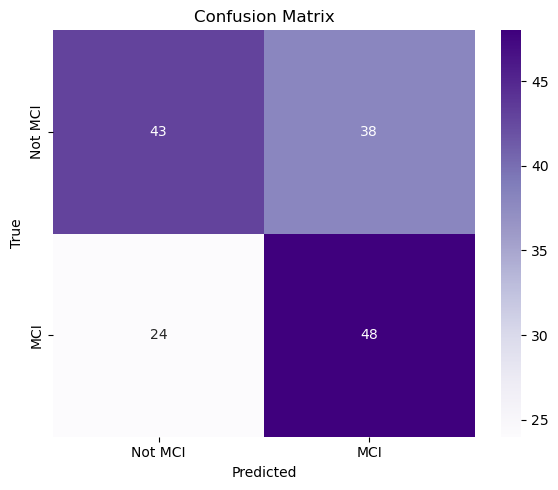

In [279]:

# --------------------- Tensor Conversion ---------------------
X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

g = torch.Generator()
g.manual_seed(seed).manual_seed(seed)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    generator=g,           #  this fixes shuffling order
    num_workers=0          #  no async loading
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0
)


# --------------------- Training Setup ---------------------

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = nn.BCEWithLogitsLoss()
best_model_state = {k: v.clone().detach().cpu() for k, v in model.state_dict().items()}   # save initial weights
# --------------------- Train Loop ---------------------
train_losses = []
val_losses = []
num_epochs = 200
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 5  # You can tune this

early_stop = False

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # ---------------- Validate ----------------
    
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb.unsqueeze(1).float())
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # -------- Early Stopping Check --------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            early_stop = True
            break
gc.collect()
torch.cuda.empty_cache()

# --------------------- Evaluate on Training Set ---------------------
model.load_state_dict(best_model_state)
model.eval()
y_train_preds = []
y_train_true = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = (torch.sigmoid(out).squeeze() > 0.5).int()
        preds = preds.int()  # Convert to integer class (0 or 1)
        y_train_preds.extend(preds.cpu().numpy())
        y_train_true.extend(yb.numpy().astype(int))

train_acc = accuracy_score(y_train_true, y_train_preds)
print(f" Training Accuracy: {train_acc:.4f}")


# --------------------- Evaluate on Validation Set ---------------------
y_val_preds = []
y_val_true = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = torch.sigmoid(out).squeeze() > 0.5
        preds = preds.int()  # Convert to integer class (0 or 1)
        y_val_preds.extend(preds.cpu().numpy())
        y_val_true.extend(yb.numpy())

val_acc = accuracy_score(y_val_true, y_val_preds)
print(f" Validation Accuracy: {val_acc:.4f}")
print("\nClassification Report:\n", classification_report(y_val_true, y_val_preds, target_names=["Not MCI", "MCI"]))

# --------------------- Confusion Matrix ---------------------
cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Not MCI", "MCI"], yticklabels=["Not MCI", "MCI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix")
plt.tight_layout()
plt.show()

 Early stopping triggered at epoch 20
 Final Training Loss: 0.6194
 Final Validation Loss: 0.6653


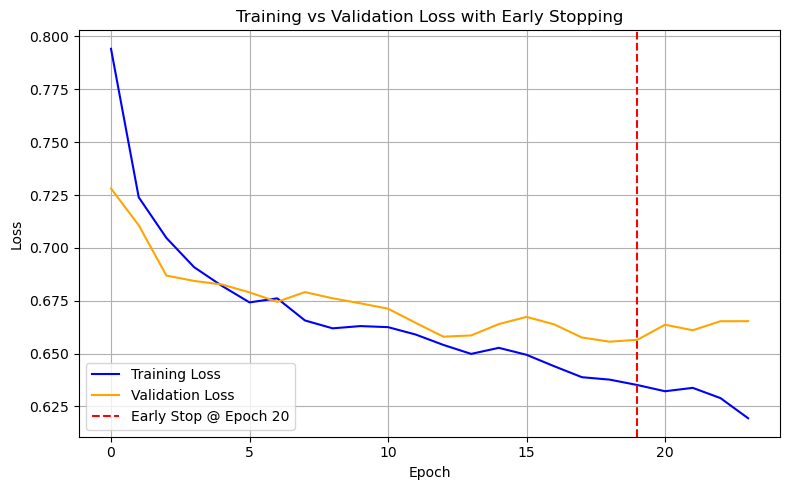

In [280]:
import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="orange")

# Mark early stopping point
if early_stop:
    early_stop_epoch = len(train_losses) - patience
    plt.axvline(x=early_stop_epoch, color="red", linestyle="--", label=f"Early Stop @ Epoch {early_stop_epoch+1}")
    print(f" Early stopping triggered at epoch {early_stop_epoch+1}")
else:
    print(" Training completed without early stopping")

# Final loss values
print(f" Final Training Loss: {train_losses[-1]:.4f}")
print(f" Final Validation Loss: {val_losses[-1]:.4f}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss with Early Stopping")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming y_test and y_pred are already defined from your previous evaluation

# Define class labels (you can update these if your label encoding is different)
class_names = ["Not MCI", "MCI"]

# Accuracy
accuracy = accuracy_score(y_val_true, y_val_preds)
print(f"\n Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-score
print("\n Classification Report:")
print(classification_report(y_val_true, y_val_preds, target_names=class_names))



 Accuracy: 0.4902

 Classification Report:
              precision    recall  f1-score   support

          AD       0.38      0.53      0.44        34
          CN       0.54      0.60      0.57        47
         MCI       0.55      0.40      0.46        72

    accuracy                           0.49       153
   macro avg       0.49      0.51      0.49       153
weighted avg       0.51      0.49      0.49       153



	.   ✅ Replace np.concatenate() fusion with a trainable layer
	•	✅ Try BioCLIP or medical image-pretrained models
	•	✅ Improve tabular/text embedding via BioBERT or using key columns only
	•	✅ Regularize fusion with modality dropout
	•	✅ (Optional) Try late fusion/ensemble as a baseline